In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import shap

import warnings
warnings.filterwarnings("ignore")

print("✅ Ready to go!")

✅ Ready to go!


In [2]:
import pandas as pd

product_df = pd.read_csv("product_info.csv")

file_list = [
    "reviews_0-250.csv",
    "reviews_250-500.csv",
    "reviews_500-750.csv",
    "reviews_750-1250.csv",
    "reviews_1250-end.csv"
]

review_df = pd.concat([pd.read_csv(file) for file in file_list], ignore_index=True)

print("Product shape:", product_df.shape)
print("Review shape:", review_df.shape)

product_df.head()



Product shape: (8494, 27)
Review shape: (1094411, 19)


,product_id,product_name,brand_id,brand_name,loves_count,rating,reviews,size,variation_type,variation_value,...,online_only,out_of_stock,sephora_exclusive,highlights,primary_category,secondary_category,tertiary_category,child_count,child_max_price,child_min_price
0,P473671,Fragrance Discovery Set,6342,19-69,6320,3.6364,11.0,NaN,NaN,NaN,...,1,0,0,"['Unisex/ Genderless Scent', 'Warm &Spicy Scen...",Fragrance,Value & Gift Sets,Perfume Gift Sets,0,NaN,NaN
1,P473668,La Habana Eau de Parfum,6342,19-69,3827,4.1538,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,85.0,30.0
2,P473662,Rainbow Bar Eau de Parfum,6342,19-69,3253,4.2500,16.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0
3,P473660,Kasbah Eau de Parfum,6342,19-69,3018,4.4762,21.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0
4,P473658,Purple Haze Eau de Parfum,6342,19-69,2691,3.2308,13.0,3.4 oz/ 100 mL,Size + Concentration + Formulation,3.4 oz/ 100 mL,...,1,0,0,"['Unisex/ Genderless Scent', 'Layerable Scent'...",Fragrance,Women,Perfume,2,75.0,30.0


In [3]:
review_df = pd.concat([pd.read_csv(file) for file in file_list], ignore_index=True)

print("Number of reviews:", review_df.shape[0])
print("\n📄 Sample 10 Reviews:")
print(review_df.head(10))


Number of reviews: 1094411

📄 Sample 10 Reviews:
   Unnamed: 0    author_id  rating  is_recommended  helpfulness  \
0           0   1741593524       5             1.0         1.00   
1           1  31423088263       1             0.0          NaN   
2           2   5061282401       5             1.0          NaN   
3           3   6083038851       5             1.0          NaN   
4           4  47056667835       5             1.0          NaN   
5           5  42802569154       4             1.0         1.00   
6           6   6941883808       2             0.0         0.25   
7           7  27926227988       5             1.0          NaN   
8           8   7656791726       5             1.0         1.00   
9           9  38727834382       5             1.0         1.00   

   total_feedback_count  total_neg_feedback_count  total_pos_feedback_count  \
0                     2                         0                         2   
1                     0                         0      

In [4]:


product_df = pd.read_csv("product_info.csv", encoding="utf-8")
review_df = pd.read_csv("reviews_0-250.csv", encoding="utf-8")


print("📦 Product Columns:")
print(product_df.columns.tolist())

print("\n📝 Review Columns:")
print(review_df.columns.tolist())


📦 Product Columns:
['product_id', 'product_name', 'brand_id', 'brand_name', 'loves_count', 'rating', 'reviews', 'size', 'variation_type', 'variation_value', 'variation_desc', 'ingredients', 'price_usd', 'value_price_usd', 'sale_price_usd', 'limited_edition', 'new', 'online_only', 'out_of_stock', 'sephora_exclusive', 'highlights', 'primary_category', 'secondary_category', 'tertiary_category', 'child_count', 'child_max_price', 'child_min_price']

📝 Review Columns:
['Unnamed: 0', 'author_id', 'rating', 'is_recommended', 'helpfulness', 'total_feedback_count', 'total_neg_feedback_count', 'total_pos_feedback_count', 'submission_time', 'review_text', 'review_title', 'skin_tone', 'eye_color', 'skin_type', 'hair_color', 'product_id', 'product_name', 'brand_name', 'price_usd']


In [5]:

merged_df = review_df.merge(product_df, on="product_id", how="left")

categories = merged_df["tertiary_category"].dropna().unique()
categories.sort()

for cat in categories:
    print(cat)


BB & CC Creams
Blemish & Acne Treatments
Exfoliators
Eye Creams & Treatments
Eye Masks
Face Masks
Face Oils
Face Serums
Face Sunscreen
Face Wash & Cleansers
Face Wipes
Facial Peels
For Face
Makeup Removers
Mists & Essences
Moisturizers
Night Creams
Toners


In [6]:
merged_df['positive'] = (merged_df['rating_x'] >= 4) | (merged_df['is_recommended'] == True)

grouped = merged_df.groupby(['product_id', 'skin_type']).agg(
    total_reviews=('positive', 'count'),
    positive_reviews=('positive', 'sum')
).reset_index()

grouped['positive_ratio'] = grouped['positive_reviews'] / grouped['total_reviews']
grouped['recommended'] = (grouped['total_reviews'] >= 3) & (grouped['positive_ratio'] >= 0.7)

grouped = grouped.merge(
    merged_df[['product_id', 'product_name_x', 'brand_name_x', 'ingredients']].drop_duplicates(),
    on='product_id',
    how='left'
)

grouped[grouped['recommended'] == True].head(10)



,product_id,skin_type,total_reviews,positive_reviews,positive_ratio,recommended,product_name_x,brand_name_x,ingredients
0,P114902,combination,525,460,0.876190,True,Goodbye Acne Max Complexion Correction Pads,Peter Thomas Roth,"['Salicylic Acid 2%, Alcohol Denat., Water/Aqu..."
1,P114902,dry,66,56,0.848485,True,Goodbye Acne Max Complexion Correction Pads,Peter Thomas Roth,"['Salicylic Acid 2%, Alcohol Denat., Water/Aqu..."
2,P114902,normal,74,66,0.891892,True,Goodbye Acne Max Complexion Correction Pads,Peter Thomas Roth,"['Salicylic Acid 2%, Alcohol Denat., Water/Aqu..."
3,P114902,oily,249,222,0.891566,True,Goodbye Acne Max Complexion Correction Pads,Peter Thomas Roth,"['Salicylic Acid 2%, Alcohol Denat., Water/Aqu..."
4,P12045,combination,655,586,0.894656,True,Grape Water Moisturizing Face Mist,Caudalie,"['Vitis Vinifera (Grape) Fruit Water*, Vitis V..."
5,P12045,dry,254,214,0.842520,True,Grape Water Moisturizing Face Mist,Caudalie,"['Vitis Vinifera (Grape) Fruit Water*, Vitis V..."
6,P12045,normal,111,99,0.891892,True,Grape Water Moisturizing Face Mist,Caudalie,"['Vitis Vinifera (Grape) Fruit Water*, Vitis V..."
7,P12045,oily,130,111,0.853846,True,Grape Water Moisturizing Face Mist,Caudalie,"['Vitis Vinifera (Grape) Fruit Water*, Vitis V..."
8,P122718,combination,399,371,0.929825,True,Exfoliating Face Scrub,CLINIQUE,"['Water\\Aqua\\Eau, Glyceryl Stearate, Silica,..."
9,P122718,dry,51,42,0.823529,True,Exfoliating Face Scrub,CLINIQUE,"['Water\\Aqua\\Eau, Glyceryl Stearate, Silica,..."


In [7]:
grouped[(grouped['skin_type'] == 'normal') & (grouped['recommended'] == True)]




,product_id,skin_type,total_reviews,positive_reviews,positive_ratio,recommended,product_name_x,brand_name_x,ingredients
2,P114902,normal,74,66,0.891892,True,Goodbye Acne Max Complexion Correction Pads,Peter Thomas Roth,"['Salicylic Acid 2%, Alcohol Denat., Water/Aqu..."
6,P12045,normal,111,99,0.891892,True,Grape Water Moisturizing Face Mist,Caudalie,"['Vitis Vinifera (Grape) Fruit Water*, Vitis V..."
10,P122718,normal,48,44,0.916667,True,Exfoliating Face Scrub,CLINIQUE,"['Water\\Aqua\\Eau, Glyceryl Stearate, Silica,..."
14,P122774,normal,179,141,0.787709,True,All About Eyes Eye Cream,CLINIQUE,"['Cyclopentasiloxane, Water, Isostearyl Palmit..."
18,P122882,normal,158,131,0.829114,True,Clarifying Lotion 2,CLINIQUE,"['Water\\Aqua\\Eau, Alcohol Denat., Glycerin, ..."
...,...,...,...,...,...,...,...,...,...
979,P504595,normal,344,311,0.904070,True,Mini Rice Wash Skin-Softening Cleanser,Tatcha,"['Aqua/Water/Eau, Microcrystalline Cellulose, ..."
983,P504615,normal,265,205,0.773585,True,Mini Deep Cleanse Gentle Exfoliating Cleanser,Tatcha,"['Water, Sodium Cocoyl Glutamate, Propanediol,..."
987,P54509,normal,215,205,0.953488,True,Tonique Confort Re-Hydrating Comforting Toner ...,Lancôme,"['Aqua/Water, Butylene Glycol, Glycerin, Cyclo..."
991,P7880,normal,941,800,0.850159,True,Soy Hydrating Gentle Face Cleanser,fresh,"['Aqua (Water), Coco-Glucoside, Butylene Glyco..."


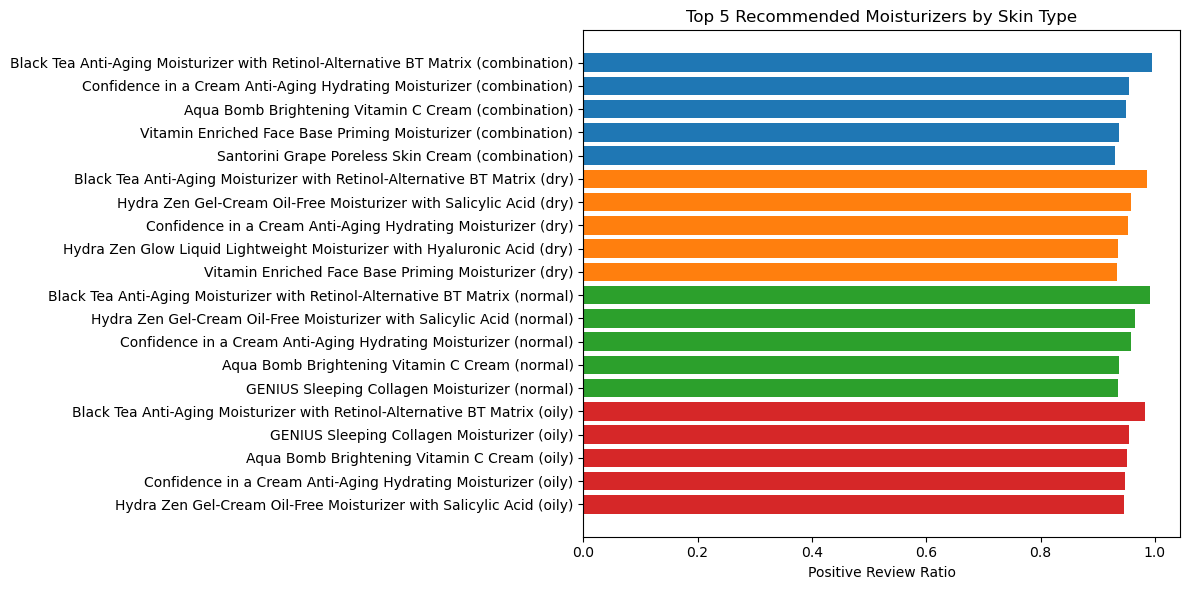

In [8]:

moisturizer_df = merged_df[merged_df['tertiary_category'] == 'Moisturizers'].copy()


moisturizer_df['positive'] = (moisturizer_df['rating_x'] >= 4) | (moisturizer_df['is_recommended'] == True)


grouped = moisturizer_df.groupby(['product_id', 'skin_type']).agg(
    total_reviews=('positive', 'count'),
    positive_reviews=('positive', 'sum')
).reset_index()


grouped['positive_ratio'] = grouped['positive_reviews'] / grouped['total_reviews']
grouped['recommended'] = (grouped['total_reviews'] >= 3) & (grouped['positive_ratio'] >= 0.7)


product_info = moisturizer_df[['product_id', 'product_name_x', 'brand_name_x', 'price_usd_x', 'ingredients']].drop_duplicates()

result = grouped.merge(product_info, on='product_id', how='left')


result = result.rename(columns={
    'product_name_x': 'product_name',
    'brand_name_x': 'brand_name',
    'price_usd_x': 'price_usd'
})

recommended_moisturizers = result[result['recommended'] == True]
recommended_moisturizers = recommended_moisturizers.sort_values(['skin_type', 'positive_ratio'], ascending=[True, False])


top5_moisturizers = recommended_moisturizers.groupby('skin_type').head(5).reset_index(drop=True)
import plotly.express as px



plt.figure(figsize=(12, 6))

for skin_type in top5_moisturizers['skin_type'].unique():
    subset = top5_moisturizers[top5_moisturizers['skin_type'] == skin_type]
    plt.barh(
        subset['product_name'] + f" ({skin_type})",  # label per bar
        subset['positive_ratio'],
        label=skin_type.capitalize()
    )

plt.xlabel("Positive Review Ratio")
plt.title("Top 5 Recommended Moisturizers by Skin Type")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



In [9]:
def product_skin_type_probabilities(product_name):

    df_product = merged_df[merged_df['product_name_x'] == product_name]
    
   
    df_product['positive'] = (df_product['rating_x'] >= 4) | (df_product['is_recommended'] == True)

    grouped = df_product.groupby('skin_type').agg(
        total=('positive', 'count'),
        positive=('positive', 'sum')
    ).reset_index()

    grouped['positive_ratio'] = grouped['positive'] / grouped['total']
    
    all_types = ['dry', 'oily', 'normal', 'combination']
    for t in all_types:
        if t not in grouped['skin_type'].values:
            grouped.loc[len(grouped)] = [t, 0, 0, 0.0]
    
    grouped = grouped.sort_values(by='skin_type').reset_index(drop=True)

    return grouped[['skin_type', 'positive_ratio']]

# Example usage:
product_skin_type_probabilities("Revitalizing Supreme+ Youth Power Creme Moisturizer")


,skin_type,positive_ratio
0,combination,0.904015
1,dry,0.906183
2,normal,0.887417
3,oily,0.915323


In [10]:
def prepare_df_with_context(merged_df):
    df = merged_df.copy()
    df['positive'] = (df['rating_x'] >= 4) | (df['is_recommended'] == True)
    df = df[(df['positive']) & df['skin_type'].notna() & df['ingredients'].notna()]

    df['ingredient_text'] = df['ingredients'].apply(
        lambda x: ', '.join(eval(x)) if isinstance(x, list) else str(x).lower()
    )

    common_ingredients = {'glycerin', 'niacinamide', 'panthenol', 'water', 'butylene glycol'}
    def remove_common(text):
        return ', '.join([i.strip() for i in text.split(',') if i.strip() not in common_ingredients])

    df['filtered_ingredients'] = df['ingredient_text'].apply(remove_common)

    df['input_text'] = df['tertiary_category'].fillna('').str.lower() + ' ' + df['filtered_ingredients']
    return df


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

def vectorize_and_label(df_ml):
    vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split(', '), min_df=3)
    X = vectorizer.fit_transform(df_ml['input_text'])

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df_ml['skin_type'])
    return X, y, vectorizer, label_encoder


In [12]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

def train_model(X, y, label_encoder):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    print("📊 Classification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    return model


In [13]:
def predict_skin_type(text_input, model, vectorizer, label_encoder):
    X_input = vectorizer.transform([text_input.lower()])
    probs = model.predict_proba(X_input)[0]

    print("🔍 Predicted skin type match probability:")
    for skin, p in zip(label_encoder.classes_, probs):
        print(f"{skin.capitalize():<12}: {p:.2%}")
def balance_dataset(df_ml, max_samples_per_class=11000):
    balanced_df = (
        df_ml.groupby('skin_type', group_keys=False)
        .apply(lambda x: x.sample(min(len(x), max_samples_per_class), random_state=42))
        .reset_index(drop=True)
    )
    return balanced_df
df_ml = prepare_df_with_context(merged_df)
df_balanced = balance_dataset(df_ml)
X, y, vectorizer, label_encoder = vectorize_and_label(df_balanced)
model = train_model(X, y, label_encoder)


📊 Classification Report:
              precision    recall  f1-score   support

 combination       0.26      0.15      0.19      2200
         dry       0.29      0.44      0.35      2200
      normal       0.28      0.26      0.27      2200
        oily       0.33      0.33      0.33      2200

    accuracy                           0.30      8800
   macro avg       0.29      0.30      0.29      8800
weighted avg       0.29      0.30      0.29      8800



In [14]:
sample_ingredients = """
Aqua, Butylene Glycol, Glycerin, Niacinamide, Panthenol, Centella Asiatica Extract,
Madecassoside, Sodium Hyaluronate, Adenosine, Beta-Glucan, Allantoin, Green Tea Extract,
Scutellaria Baicalensis Root Extract, Licorice Root Extract, Camellia Sinensis Leaf Extract,
Arginine, Carbomer, Dimethicone, Cetearyl Alcohol, 1,2-Hexanediol, Caprylyl Glycol,
Ethylhexylglycerin, Disodium EDTA, Hydroxyethylcellulose, Polyglyceryl-10 Stearate,
Tocopherol, Ceramide NP, Cholesterol, Phytosphingosine
"""
predict_skin_type(sample_ingredients, model, vectorizer, label_encoder)


🔍 Predicted skin type match probability:
Combination : 26.02%
Dry         : 29.26%
Normal      : 26.47%
Oily        : 18.24%


In [15]:
roundlab_sunscreen = """
Water, Dibutyl Adipate, Propanediol, Diethylamino Hydroxybenzoyl Hexyl Benzoate, Polymethylsilsesquioxane, Ethylhexyl Triazone, Niacinamide, Methylene Bis-Benzotriazolyl Tetramethylbutylphenol, Coco-Caprylate/​Caprate, Caprylyl Methicone, Diethylhexyl Butamido Triazone, Glycerin, 1,2-Hexanediol, Butylene Glycol, Betula Platyphylla Japonica Juice, Sodium Hyaluronate, Hydrolyzed Hyaluronic Acid, Glyceryl Glucoside, Dipotassium Glycyrrhizate, Allantoin, Portulaca Oleracea Extract, Artemisia Annua Extract, Pinus Sylvestris Leaf Extract, Chamomilla Recutita Flower Oil, Acrylates/​C10-30 Alkyl Acrylate Crosspolymer, Sodium Stearoyl Glutamate, Polyacrylate Crosspolymer-6, Ethylhexylglycerin, Ascorbic Acid, Adenosine, Pentylene Glycol, Behenyl Alcohol, Poly C10-30 Alkyl Acrylate, Polyglyceryl-3 Methylglucose Distearate, Decyl Glucoside, Tromethamine, Xanthan Gum, T-Butyl Alcohol, Tocopherol, Carbomer
"""
predict_skin_type(roundlab_sunscreen, model, vectorizer, label_encoder)


🔍 Predicted skin type match probability:
Combination : 27.41%
Dry         : 26.88%
Normal      : 26.08%
Oily        : 19.63%


In [16]:
sample_ingredients_vitc = """
Licorice Root Extract, Vitamin Tree Extract (Number 24.48%)*, Glycerin, Methylpropanediol,
Butylene Glycol, Niacinamide*, Diethoxyethyl Succinate, 1,2-Hexanediol*, Tocopheryl Acetate,
Purified Water*, Ethyl Ascorbyl Ether (15,000 Ppm)*, Bifida Ferment Lysate, Tranexamic Acid*,
Arbutin*, Ascorbic Acid (1.0005 Ppb)*, Ascorbyl Glucoside (0.00025 Ppb)*, Hydrolyzed Collagen *,
Ceramide NP*, Fullerenes, Palmitoyl Tripeptide-5, Acetyl Hexapeptide-8, Hyaluronic Acid,
Sodium Hyaluronate, Hydrolyzed Hyaluronic Acid, Glyceryl Glucoside, Tocopherol, Allantoin,
Carrot Extract, Beta-Carotene, Laurdimonium Hydroxypropyl Hydrolyzed Wheat Protein*,
Hydrogenated Lecithin*, Panthenol, Chlorella Vulgaris Extract, Soybean Oil, Eucalyptus Leaf Oil,
Lavender Oil, Orange Peel Oil, Tangerine Peel Oil, Sodium Polyacryloyldimethyl Taurate, Glucose,
Caprylic/Capric Triglyceride, Fructooligosaccharides, Fructose, Adenosine, Ethylhexylglycerin*,
Citric Acid, Polyquaternium-51, Sodium Phytate, Sodium Citrate, Caprylyl Glycol,
Dipropylene Glycol*, Pentylene Glycol*, Phytosterols*, Xanthan Gum, Limonene, Linalool
"""
predict_skin_type(sample_ingredients_vitc, model, vectorizer, label_encoder)


🔍 Predicted skin type match probability:
Combination : 28.83%
Dry         : 26.19%
Normal      : 27.48%
Oily        : 17.50%


In [17]:
sample_ingredients_aestura = """
Water/​Aqua/​Eau, Glycerin, Butylene Glycol, Butylene Glycol Dicaprylate/​Dicaprate, Pentaerythrityl Tetraisostearate, Cyclopentasiloxane, Squalane, Cetyl Ethylhexanoate, Behenyl Alcohol, Stearic Acid, Hydroxypropyl Bispalmitamide MEA, Cyclohexasiloxane, C14-22 Alcohols, Hydroxypropyl Bislauramide Mea, Mannitol, Arachidyl Alcohol, Cholesterol, Polyacrylate-13, Allantoin, Copernicia Cerifera (Carnauba) Wax Extract, C12-20 Alkyl Glucoside, Arachidyl Glucoside, Dimethiconol, Polyisobutene, Phytosphingosine, Glyceryl Caprylate, Acrylates/​Ammonium Methacrylate Copolymer, Carbomer, Tromethamine, Ethylhexylglycerin, Silica, Polysorbate 20, Sorbitan Isostearate, Glucose, Arachidic Acid, Palmitic Acid, Caesalpinia Sappan Stem Powder, Oleic Acid, Tocopherol"""
predict_skin_type(sample_ingredients_aestura, model, vectorizer, label_encoder)


🔍 Predicted skin type match probability:
Combination : 24.89%
Dry         : 34.57%
Normal      : 20.16%
Oily        : 20.38%


In [18]:
sample_ingredients_carrot = """Daucus Carota Sativa (Carrot) Root Extract, Glycerin, Propanediol, Methylpropanediol, Dipropylene Glycol, Water, Butylene Glycol, Diethoxyethyl Succinate, PPG-13-Decyltetradeceth-24, 1,2-Hexanediol, Betaine, Ethylhexylglycerin, Panthenol, Undaria Pinnatifida Extract, Sodium Carbomer, Acrylates/​C10-30 Alkyl Acrylate Crosspolymer, Allantoin, Carbomer, Sodium Hyaluronate, Glyceryl Acrylate/​Acrylic Acid Copolymer, Daucus Carota Sativa (Carrot) Seed Oil, Sodium Phytate, Maltodextrin, Beta-Glucan, Saccharide Hydrolysate, Caprylyl Glycol, Olea Europaea (Olive) Fruit Oil, Pogostemon Cablin Oil, Butyrospermum Parkii (Shea) Butter, Octyldodecanol, Hydrogenated Lecithin, Lavandula Hybrida Oil, Salvia Officinalis (Sage) Oil, Artemisia Vulgaris Oil, Citrus Aurantium Dulcis (Orange) Peel Oil, Xanthan Gum, Glyceryl Citrate/​Lactate/​Linoleate/​Oleate, Hydroxyethyl Acrylate/​Sodium Acryloyldimethyl Taurate Copolymer, Glyceryl Oleate, Glycolipids, Glycosphingolipids, Tocopherol, Ceramide NP"""
predict_skin_type(sample_ingredients_aestura, model, vectorizer, label_encoder)

🔍 Predicted skin type match probability:
Combination : 24.89%
Dry         : 34.57%
Normal      : 20.16%
Oily        : 20.38%
